In [39]:
import numpy as np
from scipy.linalg import cholesky, eigvalsh, eigh
import time
import matplotlib.pyplot as plt
import pandas as pd

In [40]:
def chol_pd(a):

    n = a.shape[0]
    root = np.zeros_like(a)

    for j in range(n):
        s = 0.0
        if j > 0:
            s = np.dot(root[j, :j], root[j, :j])

        root[j, j] = np.sqrt(a[j, j] - s)

        ir = 1.0 / root[j, j]
        for i in range(j + 1, n):
            s = np.dot(root[i, :j], root[j, :j])
            root[i, j] = (a[i, j] - s) * ir

    return root

def chol_psd(a, tol=1e-8):

    n = a.shape[0]
    root = np.zeros_like(a)

    for j in range(n):
        s = 0.0
        if j > 0:
            s = np.dot(root[j, :j], root[j, :j])

        temp = a[j, j] - s
        if temp < 0 and temp >= -tol:
            temp = 0.0
        elif temp < -tol:
            raise np.linalg.LinAlgError("Matrix is not positive semi-definite")

        root[j, j] = np.sqrt(temp)

        if root[j, j] > 0.0:
            ir = 1.0 / root[j, j]
            for i in range(j + 1, n):
                s = np.dot(root[i, :j], root[j, :j])
                root[i, j] = (a[i, j] - s) * ir

    return root

n = 5
sigma = np.full((n, n), 0.9)
np.fill_diagonal(sigma, 1.0)

sigma[0, 1] = 1.0
sigma[1, 0] = 1.0

eigenvalues = np.linalg.eigvals(sigma)
print("Eigenvalues:", eigenvalues)

root = chol_psd(sigma)
reconstructed_sigma = root @ root.T
print("Reconstructed Sigma matches original:", np.allclose(sigma, reconstructed_sigma))

Eigenvalues: [4.64053565e+00 1.50909392e-16 1.59464350e-01 1.00000000e-01
 1.00000000e-01]
Reconstructed Sigma matches original: True


In [41]:
def near_psd(a, epsilon=0):

    n = a.shape[0]
    w, v = eigh(a)
    w = np.maximum(w, epsilon)
    T = v * np.sqrt(w)
    return T @ T.T

n = 500
sigma = np.full((n, n), 0.9)
np.fill_diagonal(sigma, 1.0)
sigma[0, 1] = 0.7357
sigma[1, 0] = 0.7357

eigenvalues = eigvalsh(sigma)
print("Minimum eigenvalue before fixing:", np.min(eigenvalues))

sigma_near_psd = near_psd(sigma)

eigenvalues_fixed = eigvalsh(sigma_near_psd)
print("Minimum eigenvalue after fixing:", np.min(eigenvalues_fixed))

Minimum eigenvalue before fixing: -0.06364303890470846
Minimum eigenvalue after fixing: 1.2936040991650863e-13


In [42]:
def higham_nearest_psd(matrix, tol=1e-8, max_iter=100):

    n = matrix.shape[0]
    Y = matrix.copy()
    deltaS = np.zeros_like(matrix)
    for k in range(max_iter):
        R = Y - deltaS
        X = (R + R.T) / 2
        
        eigvals, eigvecs = np.linalg.eigh(X)
        
        eigvals_clipped = np.maximum(eigvals, 0)
        
        X_psd = eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T
        
        deltaS = X_psd - R
        Y = X_psd
        
        if np.linalg.norm(deltaS, 'fro') < tol:
            break

    return X_psd

In [43]:
fro_norm_original = np.linalg.norm(sigma - sigma_near_psd, 'fro')
print("Frobenius Norm between original and fixed matrix:", fro_norm_original)

start_time = time.time()
sigma_near_psd = near_psd(sigma)
time_near_psd = time.time() - start_time

print("Time taken by near_psd function:", time_near_psd, "seconds")


Frobenius Norm between original and fixed matrix: 0.0636430389046896
Time taken by near_psd function: 0.014998912811279297 seconds


In [44]:
def simulate_pca(a, nsim, nval=None):

    vals, vecs = eigh(a)

    idx = np.argsort(vals)[::-1]
    vals = vals[idx]
    vecs = vecs[:, idx]

    total_variance = np.sum(vals)
    positive_eigenvalues = vals[vals > 1e-8]

    if nval is not None and nval < len(positive_eigenvalues):
        vals = vals[:nval]
        vecs = vecs[:, :nval]
    else:
        vals = positive_eigenvalues
        vecs = vecs[:, :len(vals)]

    explained_variance = np.sum(vals) / total_variance * 100
    print(f"Simulating with {len(vals)} principal components: {explained_variance:.2f}% total variance explained")

    B = vecs @ np.diag(np.sqrt(vals))
    r = np.random.randn(len(vals), nsim)
    simulated_data = (B @ r).T
    return simulated_data

n = 5
sigma = np.full((n, n), 0.9)
np.fill_diagonal(sigma, 1.0)
sigma[0, 1] = 1.0
sigma[1, 0] = 1.0

v = np.diag([0.5] * n)
sigma = v @ sigma @ v

sim = simulate_pca(sigma, 10000)
print("Covariance of simulated data:\n", np.cov(sim, rowvar=False))

sim = simulate_pca(sigma, 10000, nval=3)
print("Covariance of simulated data with 3 PCs:\n", np.cov(sim, rowvar=False))

sim = simulate_pca(sigma, 10000, nval=2)
print("Covariance of simulated data with 2 PCs:\n", np.cov(sim, rowvar=False))

Simulating with 4 principal components: 100.00% total variance explained
Covariance of simulated data:
 [[0.25053981 0.25053981 0.22502266 0.22589815 0.22312757]
 [0.25053981 0.25053981 0.22502266 0.22589815 0.22312757]
 [0.22502266 0.22502266 0.24942494 0.2253886  0.22358177]
 [0.22589815 0.22589815 0.2253886  0.25161733 0.22416023]
 [0.22312757 0.22312757 0.22358177 0.22416023 0.2471185 ]]
Simulating with 3 principal components: 98.00% total variance explained
Covariance of simulated data with 3 PCs:
 [[0.24742779 0.24742779 0.22347194 0.22311312 0.22383075]
 [0.24742779 0.24742779 0.22347194 0.22311312 0.22383075]
 [0.22347194 0.22347194 0.23274488 0.23227877 0.23321099]
 [0.22311312 0.22311312 0.23227877 0.24455041 0.22000714]
 [0.22383075 0.22383075 0.23321099 0.22000714 0.24641483]]
Simulating with 2 principal components: 96.00% total variance explained
Covariance of simulated data with 2 PCs:
 [[0.25151028 0.25151028 0.22639617 0.22639617 0.22639617]
 [0.25151028 0.25151028 0.22

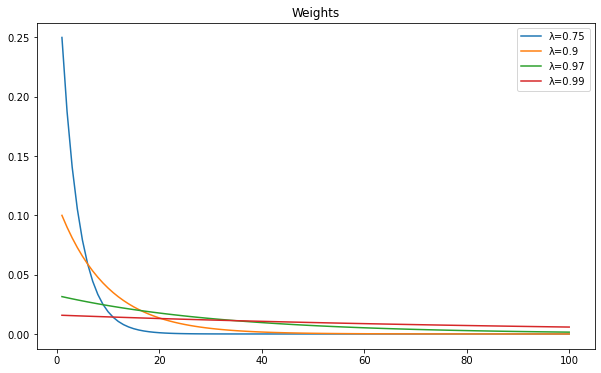

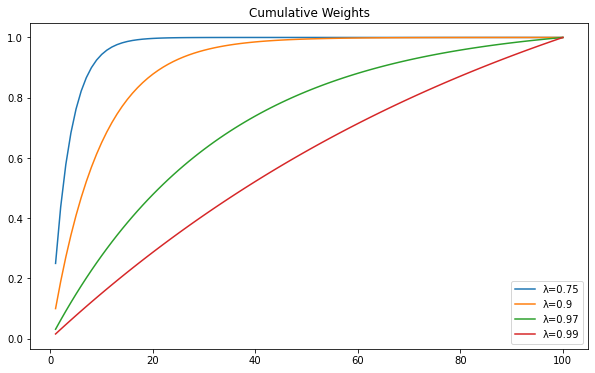

In [45]:
def populate_weights(n, lambd):

    x = np.arange(1, n + 1)
    w = np.array([(1 - lambd) * lambd**i for i in range(n)])
    cumulative_w = np.cumsum(w)
    w /= cumulative_w[-1]
    cumulative_w /= cumulative_w[-1]
    return x, w, cumulative_w

n = 100
lambdas = [0.75, 0.90, 0.97, 0.99]
weights_df = pd.DataFrame()
cumulative_weights_df = pd.DataFrame()

for lambd in lambdas:
    x, w, cumulative_w = populate_weights(n, lambd)
    weights_df[f'λ={lambd}'] = w
    cumulative_weights_df[f'λ={lambd}'] = cumulative_w

weights_df['x'] = x
cumulative_weights_df['x'] = x

plt.figure(figsize=(10, 6))
for lambd in lambdas:
    plt.plot(weights_df['x'], weights_df[f'λ={lambd}'], label=f'λ={lambd}')
plt.title('Weights')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for lambd in lambdas:
    plt.plot(cumulative_weights_df['x'], cumulative_weights_df[f'λ={lambd}'], label=f'λ={lambd}')
plt.title('Cumulative Weights')
plt.legend()
plt.show()


In [46]:
def generate_with_missing(n, m, pmiss=0.25):

    x = np.random.randn(n, m)
    mask = np.random.rand(n, m) < pmiss
    x[mask] = np.nan
    return x

np.random.seed(2)
x = generate_with_missing(10, 5, pmiss=0.2)

def missing_cov(x, skip_miss=True, func=np.cov):

    n, m = x.shape
    if np.isnan(x).sum() == 0:
        return func(x, rowvar=False)

    if skip_miss:
        valid_rows = ~np.isnan(x).any(axis=1)
        return func(x[valid_rows], rowvar=False)
    else:
        out = np.zeros((m, m))
        for i in range(m):
            for j in range(i + 1):
                valid_rows = ~np.isnan(x[:, [i, j]]).any(axis=1)
                if valid_rows.sum() > 1:
                    cov_ij = func(x[valid_rows][:, [i, j]].T)
                    out[i, j] = cov_ij[0, 1]
                    out[j, i] = out[i, j]
                else:
                    out[i, j] = np.nan
                    out[j, i] = np.nan
        return out

skip_miss_cov = missing_cov(x)
pairwise_cov = missing_cov(x, skip_miss=False)

eigenvalues_pairwise = np.linalg.eigvals(pairwise_cov)
print("Eigenvalues of pairwise covariance matrix:", eigenvalues_pairwise)

root_skip_miss = chol_psd(skip_miss_cov)
root_pairwise = chol_psd(pairwise_cov)

Eigenvalues of pairwise covariance matrix: [2.59108586 1.48288463 0.55698325 0.02037401 0.27002419]


In [38]:
import time

def frobenius_norm(matrix1, matrix2):
    return np.linalg.norm(matrix1 - matrix2, 'fro')

n_values = [100, 200, 500, 1000]
times_chol_psd = []
times_near_psd = []
times_higham = []
frobenius_chol_psd = []
frobenius_near_psd = []
frobenius_higham = []

for n in n_values:
    sigma = np.full((n, n), 0.9)
    np.fill_diagonal(sigma, 1.0)
    sigma[0, 1] = 0.7357
    sigma[1, 0] = 0.7357

    start_time = time.time()
    sigma_near_psd = near_psd(sigma)
    times_near_psd.append(time.time() - start_time)
    frobenius_near_psd.append(frobenius_norm(sigma, sigma_near_psd))

    start_time = time.time()
    sigma_higham_psd = higham_nearest_psd(sigma)
    times_higham.append(time.time() - start_time)
    frobenius_higham.append(frobenius_norm(sigma, sigma_higham_psd))

print("Near PSD Times:", times_near_psd)
print("Higham PSD Times:", times_higham)
print("Frobenius Norms (Near PSD):", frobenius_near_psd)
print("Frobenius Norms (Higham PSD):", frobenius_higham)

Near PSD Times: [0.003000497817993164, 0.0009999275207519531, 0.017000675201416016, 0.09699749946594238]
Higham PSD Times: [0.06900310516357422, 0.20299601554870605, 2.1350016593933105, 17.37837862968445]
Frobenius Norms (Near PSD): [0.061019868514893986, 0.06265848337003005, 0.0636430389046896, 0.06397145985688157]
Frobenius Norms (Higham PSD): [0.06101986851489391, 0.06265848337002992, 0.06364303890468949, 0.06397145985688116]
